# Basis embedding (pennylane)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 4 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-5.2640736e-03-1.0503981e-02j  5.3403111e+01+2.6179874e+01j
  -9.7928848e-03-1.4683907e-02j  8.7683974e-03+5.8064552e-04j]
 [ 3.5036755e+01+6.6007317e+01j  2.0446012e+01+7.6937294e+01j
   9.6606552e+01+5.0116463e+01j -1.1645260e-03+1.7880008e-02j]
 [ 7.1948273e+01+6.6368923e+00j  7.6370308e+01+3.0140392e+01j
   9.4824600e+01+4.0863445e+01j  3.8004969e-03-6.6925986e-03j]
 [-1.4208330e-02-1.6492251e-02j  6.7600355e-05-8.6763566e-03j
   5.4684444e-03-3.9711446e-03j  6.2608710e-03-5.6655770e-03j]]


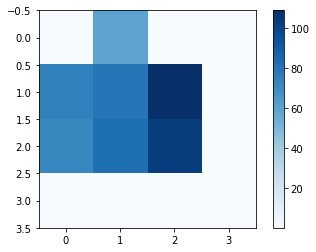

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 448.62955  +296.83347j    48.78151  -168.54587j
   148.15521   +30.323479j -217.70406  +131.85779j ]
 [   3.3635993-203.56934j    14.36307   +41.830593j
  -104.65097  -154.78581j    63.20539  +149.73111j ]
 [ 144.45805   -89.254845j   18.127651 -159.42058j
   -74.21156   -48.001488j   59.3077    +59.21916j ]
 [-382.86392  +100.61179j    23.46306   +72.5752j
  -183.00043   +67.64124j    -9.508098 -127.21398j ]]


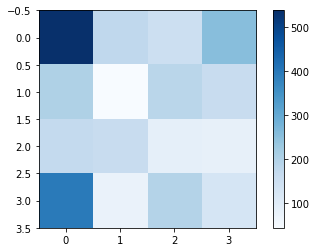

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: ' + str(test_imag))

Reals MSE: 5.2202323e-13
Imaginaries MSE: 7.4817073e-13


C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcpara

(<Figure size 432x504 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x2189b1c65e0>)

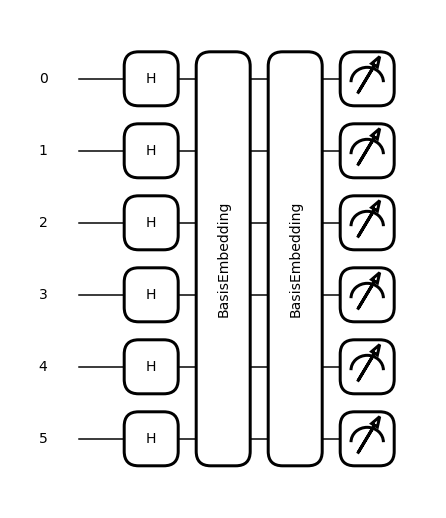

In [8]:
from pennylane.templates.embeddings import BasisEmbedding
# quantum device where you want to run and how many Qubits
dev = qml.device('default.qubit', wires=6)

@qml.qnode(dev)
def circuit(data):
    for i in range(6):
        qml.Hadamard(i)
    for i in range(len(data)):
        BasisEmbedding(features=data[i], wires=range(6),do_queue=True)
    return  qml.state()

data=[[1,0,1,1,1,0],
      [1,0,0,0,0,1]]

circuit(data)

qml.draw_mpl(circuit)(data)

## 3) Data encoding: basis embedding (non-conventional domain)

In [9]:
from pennylane.templates.embeddings import BasisEmbedding

# vectorize input data
data = visibilities.flatten()

# get binary representations of real and imaginary parts
data_reals = []
data_imags = []
for i in range(0, len(data)):
    data_reals.append(float_to_bin_real(data[i].real))
    data_imags.append(float_to_bin_imag(data[i].imag))

# combine binary representations into a single array (reals then imaginaries)
data_binaries = data_reals + data_imags 

# sparse all binary representations strings into single characters
data_binary = []
for i in range(0, len(data_binaries)):
    data_binary.append([*data_binaries[i]])

# make all character-strings integers
inp = []
for i in range(0, len(data_binaries)):
    inp.append([int(data_binaries[i])])
    

# n bits encoded onto n quibts
wires = range(32) 
bas_dev = qml.device('default.qubit', wires) # simulator (MOTIVATION?)
print(len(inp))
# encoding
@qml.qnode(bas_dev)
def basis_encoding(inp):
    for i in wires:
        qml.Hadamard(i)
    for i in range(len(inp)):
        BasisEmbedding(features=inp[i], wires=wires, do_queue=True)
    return qml.state()

readout = basis_encoding(inp)
print(readout)

MemoryError: Unable to allocate 64.0 GiB for an array with shape (4294967296,) and data type complex128

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')